In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
print sns.__version__
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3
0.7.0


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

Here I re-wrote `runTest` to use `afwTable.matchXy()` for catalog matching (instead of my own matching).
The resulting numbers are slightly different. The old values were:
    
```
{'ZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 2, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 5, 'FN': 25, 'TP': 25}}
```

In [3]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=False, skyLimited=True)
res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 3, 'FN': 23, 'TP': 27}, 'ALstack': {'FP': 1, 'FN': 24, 'TP': 26}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 3, 'FN': 23, 'TP': 27}}


Do forced phot. now with funcs in diffimTests:

In [4]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

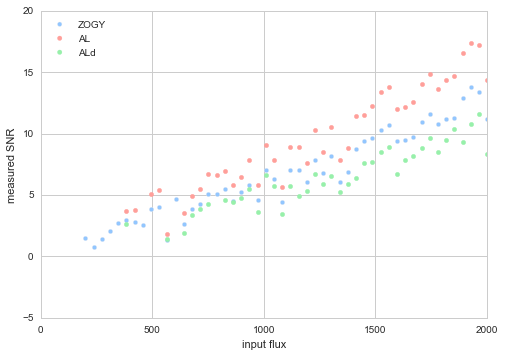

In [5]:
plt.scatter(sources['inputFlux_science'], fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 2000);

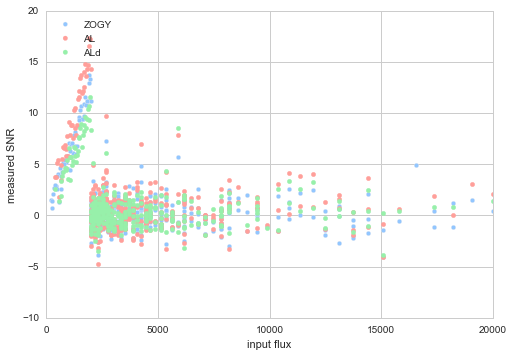

In [6]:
cats = testObj.doForcedPhot(transientsOnly=False)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
plt.scatter(sources['inputFlux_science'], fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 20000);

Figure out matching. Match sources detected in ZOGY diffim to input transients.

In [7]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
dit.sizeme(dit.catalogToDF(sources).head())

,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
0,190.250055,268.522124,0.928081,3.761632,1,1853.061224,0.0,0
1,433.697910,382.514098,0.927976,3.761995,2,751.020408,0.0,0
2,139.374588,229.931702,0.928116,3.761556,3,1559.183673,0.0,0
3,139.514874,217.867398,0.928126,3.761556,4,1485.714286,0.0,0
4,462.770744,506.683469,0.927865,3.762039,5,200.000000,0.0,0


Cross-reference the *detections* in ZOGY (`src['ZOGY']`) with the input sources `sources` to identify which of the 50 input transients were detected.

In [8]:
import lsst.afw.table as afwTable
import lsst.afw.table.catalogMatches as catMatch
import lsst.daf.base as dafBase
reload(dit)

matches = afwTable.matchXy(sources, src['ZOGY'], 1.0)
print len(matches)

metadata = dafBase.PropertyList()
matchCat = catMatch.matchesToCatalog(matches, metadata)
tmp = dit.catalogToDF(matchCat)
dit.sizeme(tmp.head())

26


,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

OK, we can cross-ref the `ref_id` of `matchesCat` with `id` of `sources`.

In [9]:
dit.sizeme(tmp[np.in1d(tmp['ref_id'], [1,2,3,4,5])])

,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

In [10]:
def plotWithDetectionsHighlighted(fp_DIFFIM=fp_ZOGY, label='ZOGY', color='b',
                                 addPresub=False, xaxisIsScienceForcedPhot=False):
    if not xaxisIsScienceForcedPhot:
        srces = sources['inputFlux_science']
    else:
        srces = fp2['base_PsfFlux_flux']

    plt.scatter(srces, 
                fp_DIFFIM['base_PsfFlux_flux']/fp_DIFFIM['base_PsfFlux_fluxSigma'], 
                color=color, label=None, s=10)
    plt.scatter(srces, 
                fp_DIFFIM['base_PsfFlux_flux']/fp_DIFFIM['base_PsfFlux_fluxSigma'], 
                color='k', marker='x', label=None, s=10)

    # TBD: if xaxisIsScienceForcedPhot is True, then don't use sources['inputFlux_science'] --
    #    use fp2['base_PsfFlux_flux'] instead.

    if not xaxisIsScienceForcedPhot:
        matches = afwTable.matchXy(sources, src[label], 1.0)
        metadata = dafBase.PropertyList()
        matchCat = catMatch.matchesToCatalog(matches, metadata)
        sources_detected = dit.catalogToDF(sources)
        sources_detected = sources_detected[np.in1d(sources_detected['id'], matchCat['ref_id'])]
        sources_detected = sources_detected['inputFlux_science']
        fp_ZOGY_detected = dit.catalogToDF(fp_DIFFIM)
        fp_ZOGY_detected = fp_ZOGY_detected[np.in1d(fp_ZOGY_detected['id'], matchCat['ref_id'])]
    else:
        matches = afwTable.matchXy(fp2, src[label], 1.0)
        metadata = dafBase.PropertyList()
        matchCat = catMatch.matchesToCatalog(matches, metadata)
        sources_detected = dit.catalogToDF(fp2)
        sources_detected = sources_detected[np.in1d(sources_detected['id'], matchCat['ref_id'])]
        sources_detected = sources_detected['base_PsfFlux_flux']
        fp_ZOGY_detected = dit.catalogToDF(fp_DIFFIM)
        fp_ZOGY_detected = fp_ZOGY_detected[np.in1d(fp_ZOGY_detected['id'], matchCat['ref_id'])]

    plt.scatter(sources_detected, 
                fp_ZOGY_detected['base_PsfFlux_flux']/fp_ZOGY_detected['base_PsfFlux_fluxSigma'], 
                label=label, s=20, color=color, edgecolors='r')
    
    if addPresub: # Add measurements in original science and template images
        srces = sources['inputFlux_science']
        if xaxisIsScienceForcedPhot:
            srces = fp2['base_PsfFlux_flux']
        plt.scatter(srces, 
                    fp1['base_PsfFlux_flux']/fp1['base_PsfFlux_fluxSigma'], 
                    label='template', color='y')
        plt.scatter(srces, 
                    fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma'], 
                    label='science', color='c')

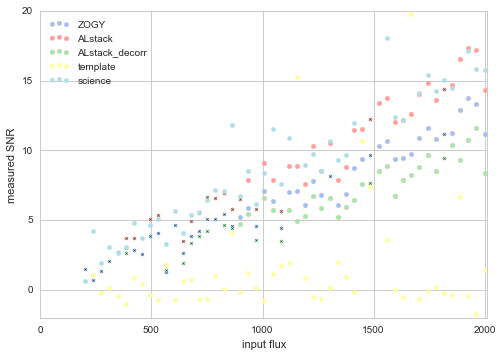

In [11]:
plotWithDetectionsHighlighted(fp_ZOGY)
plotWithDetectionsHighlighted(fp_AL, label='ALstack', color='r')
plotWithDetectionsHighlighted(fp_ALd, label='ALstack_decorr', color='g', addPresub=True)
plt.legend(loc='upper left', scatterpoints=3)
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 2010)
plt.ylim(-2, 20);

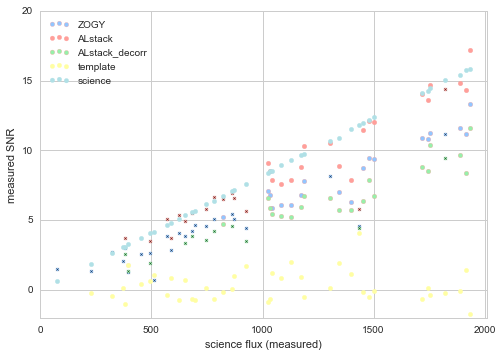

In [12]:
plotWithDetectionsHighlighted(fp_ZOGY, xaxisIsScienceForcedPhot=True)
plotWithDetectionsHighlighted(fp_AL, label='ALstack', color='r', xaxisIsScienceForcedPhot=True)
plotWithDetectionsHighlighted(fp_ALd, label='ALstack_decorr', color='g', 
                              xaxisIsScienceForcedPhot=True, addPresub=True)
plt.legend(loc='upper left', scatterpoints=3)
plt.xlabel('science flux (measured)')
plt.ylabel('measured SNR')
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Re-do with all ~5-sigma sources, and no static sources. Just for fun.

In [19]:
reload(dit)
testObj = dit.DiffimTest(n_sources=51, sourceFluxRange=(2000, 20000), 
                         #varFlux2=np.linspace(200, 2000, 50),
                         varFlux2=np.repeat(750., 50),
                         templateNoNoise=False, skyLimited=True)
res = testObj.runTest(returnSources=True, matchDist=2.) #np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 0, 'FN': 30, 'TP': 20}, 'ALstack': {'FP': 1, 'FN': 27, 'TP': 23}, 'SZOGY': {'FP': 1, 'FN': 28, 'TP': 22}, 'ALstack_decorr': {'FP': 3, 'FN': 25, 'TP': 25}}


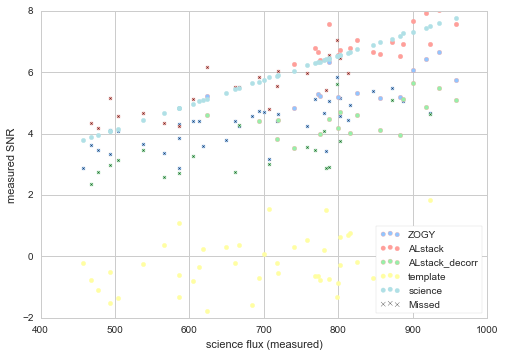

In [20]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

plotWithDetectionsHighlighted(fp_ZOGY, xaxisIsScienceForcedPhot=True)
plotWithDetectionsHighlighted(fp_AL, label='ALstack', color='r', xaxisIsScienceForcedPhot=True)
plotWithDetectionsHighlighted(fp_ALd, label='ALstack_decorr', color='g', 
                              xaxisIsScienceForcedPhot=True, addPresub=True)
plt.scatter([1000], [1000], color='k', marker='x', label='Missed')
legend = plt.legend(loc='lower right', scatterpoints=3, frameon=1)
#frame = legend.get_frame()
#frame.set_facecolor('lightgrey')
plt.xlabel('science flux (measured)')
plt.ylabel('measured SNR')
plt.xlim(400, 1000)
plt.ylim(-2, 8);